## Analysis of the Holliday-Junction opening upon stretching 15-kb DNA with HJ in the center

Artur Kaczmarczyk  | akaczmarczyk88@gmail.com   

Single Molecule Imaging Group | D. Rueda lab | Imperial College London | MRC LMS

version: June 4th

The script below loads all .h5 files from a folder that contain FD data and generate individual Force-Distance curves. 
Subsequently, every dataset is fitted with Worm-Like-Chain Model with predefined parameters.

Then, the part of the FD curve after the HJ-opening is fitted with the same persistence length and stretch modulus, leaving only the contour length as an open aprameter. The difference in the fitted contour length correspond with the step size. 





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lumicks import pylake
import os
import sys

from tkinter import filedialog        # for opening dialog window
from tkinter import *


## Import all FD curves located in a defined folder

In [56]:
# In the pop-up window, select the folder that contains .h5 files eith FD curves

root = Tk()
root.withdraw()
folder_selected = filedialog.askdirectory()
root.update()


#folder = os.getcwd( )
#filenames = os.listdir(folder)  
#Filenames = []  




# folder_selected =  r'/Users/Artur/OneDrive - Imperial College London/20200913'

filenames = os.listdir(folder_selected)          # all files in the chosen folder
Filenames = []                          

# selection of FD Curve.H5 files only

for filename in filenames:              
    if filename[-3:] == '.h5' and 'FD Curve' in filename:
        
        Filenames.append(filename)
        print(filename)
        
print(type(Filenames))

os.chdir(folder_selected)
os.getcwd()

20200911-145135 M2_15kb_HJ_60Hz FD Curve 3.h5
20201125-154927 15kb_HJ_largebeads_15Hz FD Curve 2.h5
20200911-150419 M3_15kb_HJ_60Hz FD Curve 8.h5
20201125-161355 M2_15kb_HJ_60Hz FD Curve 6.h5
20200911-150624 M3_15kb_HJ_60Hz FD Curve 9.h5
20200911-152250 M4_15kb_HJ_60Hz FD Curve 11.h5
20201125-162243 M3_15kb_HJ_60Hz FD Curve 8.h5
20200911-152623 M4_15kb_HJ_60Hz_proteinChannel FD Curve 13.h5
20200911-145517 M2_15kb_HJ_60Hz_proteinchannel FD Curve 5.h5
20200911-160955 M5_15kb_HJ_60Hz FD Curve 17.h5
20201125-162521 M4_15kb_HJ_60Hz FD Curve 9.h5
20200911-163936 M6_15kb_HJ_60Hz FD Curve 19.h5
20200911-164300 M6_15kb_HJ_60Hz FD Curve 21.h5
20200911-165857 M7_15kb_HJ_60Hz FD Curve 24.h5
20201125-163221 M5_15kb_HJ_60Hz FD Curve 11.h5
20200911-174655 M9_15kb_HJ_60Hz FD Curve 39.h5
20200911-181448 M11_15kb_HJ_60Hz FD Curve 42.h5
20201125-164144 M6_15kb_HJ_60Hz FD Curve 13.h5
20201125-155151 M1_15kb_HJ_largebeads_60Hz FD Curve 4.h5
20201125-164133 M6_15kb_HJ_60Hz_5pNclamp_ FD Curve 13.h5
20201125-

'/Volumes/ELEMENTS/Lilley/FD curves all/60 Hz constant pulling rate'

## Load WLC functions

In [3]:
### Non-extendable WLC

    ## This function returns the forces computed from a 7-parameter WLC model 
    ## [Bouchiat et al. Biophys J 76:409 (1999)]

def wlc_7param(ext, Lp, Lc):
 
    # Lp = persistence length  (in micro-m)
    # Lc = contour length      (in micro-m)
    # T  = absolute temperature (in Kelvin)
    # k_B T in units of pN micro-m
    
    #Lc = 16.49
    T = 297
    Fwlc = []
    kT = 1.3806503 * 10**(-23) *T/(10**(-18)) 
    z_L = ext/Lc

    # parameters from the paper
    my_list = [1, -0.5164228, -2.737418, 16.07497, -38.87607,  39.49944, -14.17718]   

    a = np.asarray(my_list)
    Fwlc = 1/(4*(1 - z_L)**2)  - 1/4
    
    for i in range(0,len(a)):
        Fwlc = Fwlc + a[i] * z_L**[i]


    return Fwlc * kT/Lp;


### Extendable WLC

    ## WLC model that takes stretching modulus into account


def eWLC(force, Lp, L0, S):
    F = force
    kB = 1.38e-2
    T = 297
    #S = 1800    #stretching modulus (pN)
    C = kB * T / (Lp*1000)
    
    
    d = L0 - ((L0/2)*np.sqrt(C/F)) + (F*L0/S)
    
    return(d)



def fjc(f, Pars): 
    #"""calculates a Freely Jointed Chain with a kungslength of 
    #b = 3 KbT / k*L
    #where L is the length of the fiber in nm, and k the stiffness in nm pN per nucleosome""" 
    k_Cutof = 0.2   
    if Pars['k_pN_nm'] < k_Cutof:
        Pars['k_pN_nm'] = k_Cutof
        print('>>Warning, Low stiffness, FJC breaks with low stiffness, k=', k_Cutof, 
              ' used instead. If k<', k_Cutof, ' is needed, use Hookian spring model instead')
    b = 3 * Pars['kBT_pN_nm'] / (Pars['k_pN_nm']*Pars['ZFiber_nm'])
    x = f * b / Pars['kBT_pN_nm']
    z = (np.exp(x) + 1 / np.exp(x)) / (np.exp(x) - 1 / np.exp(x)) - 1 / x
    #coth(x)= (exp(x) + exp(-x)) / (exp(x) - exp(x)) --> see Wikipedia
    #z *= Pars['L_bp']*Pars['DNAds_nm']   #work /dG term not used atm
    #z_df = (Pars['kBT_pN_nm'] / b) * (np.log(np.sinh(x)) - np.log(x))  #*L_nm #  + constant --> integrate over f (finish it
    #w = f * z - z_df
    return z * (Pars['N_tot']-Pars['N4'])




In [53]:
# LEAST SQUARE METHOD is used to fit the persistence length and the contour length beased on the non-eWLC

# Predefine the expected range (in micrometers)
PL_min = 0.025 
PL_max = 0.060
CL_min = 4
CL_max = 17
S_min = 800 # pN
S_max = 1600 #pN


# Choose the part of the data to be fitted   

force_treshold = 22     # pN  
force_treshold_min = 12  # pN

force_treshold_2nd = 32     # pN  
force_treshold_min_2nd  = 24  # pN


Force-distance curve I.D. = ['3']
Force-distance curve I.D. = ['2']
Force-distance curve I.D. = ['8']
Force-distance curve I.D. = ['6']
Force-distance curve I.D. = ['9']
Force-distance curve I.D. = ['11']
Force-distance curve I.D. = ['8']
Force-distance curve I.D. = ['13']
Force-distance curve I.D. = ['5']
Force-distance curve I.D. = ['17']
Force-distance curve I.D. = ['9']
Force-distance curve I.D. = ['19']
Force-distance curve I.D. = ['21']
Force-distance curve I.D. = ['24']
Force-distance curve I.D. = ['11']
Force-distance curve I.D. = ['39']
Force-distance curve I.D. = ['42']
Force-distance curve I.D. = ['13']
Force-distance curve I.D. = ['4']
Force-distance curve I.D. = ['13']
Force-distance curve I.D. = ['15']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['2']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['2']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['20']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['22']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['24']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['4']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['26']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['1']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['30']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['4']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['33']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['34']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['36']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['37']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['40']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['3']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['25']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['6']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['28']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['30']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['32']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['8']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['38', '39']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['10']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['11']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['14']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['16']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['17']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['18']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


Force-distance curve I.D. = ['19']


<ipython-input-62-da15941b7b83>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 6), dpi=70)


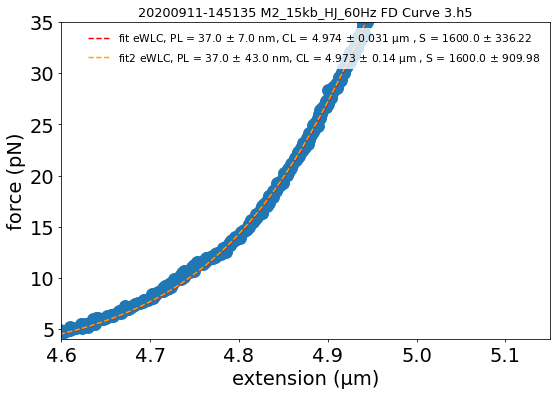

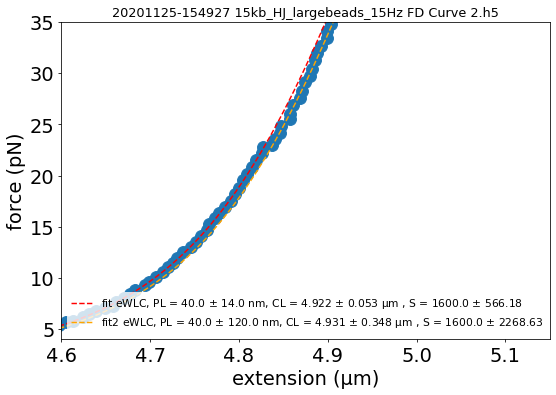

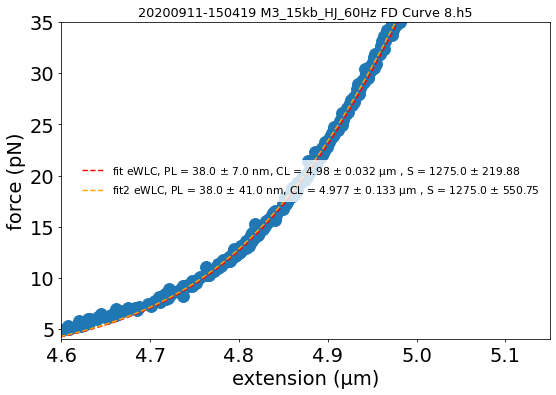

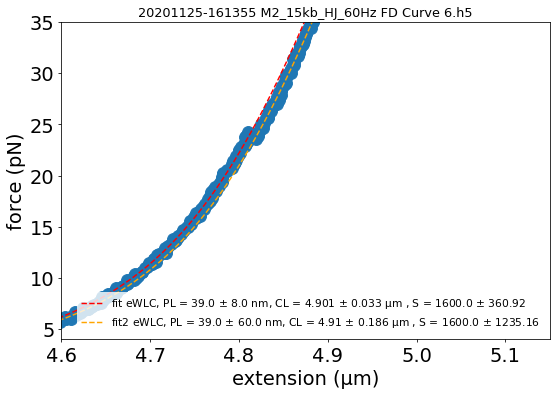

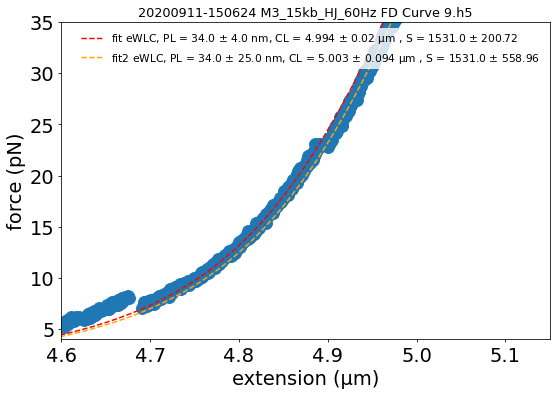

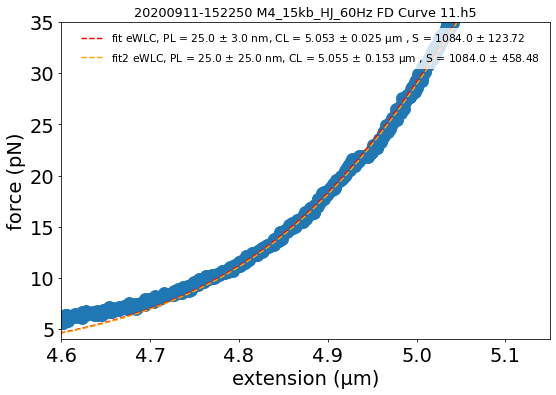

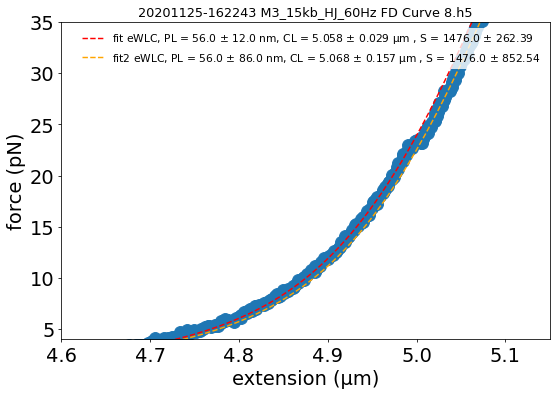

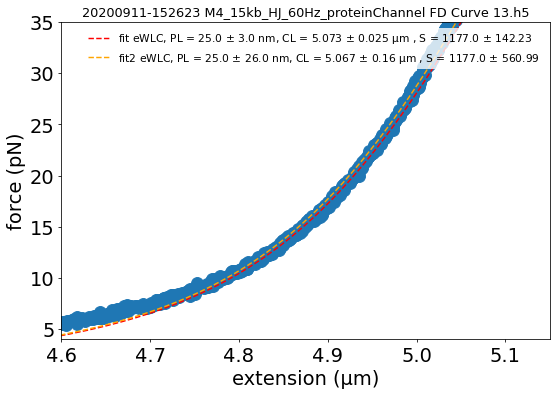

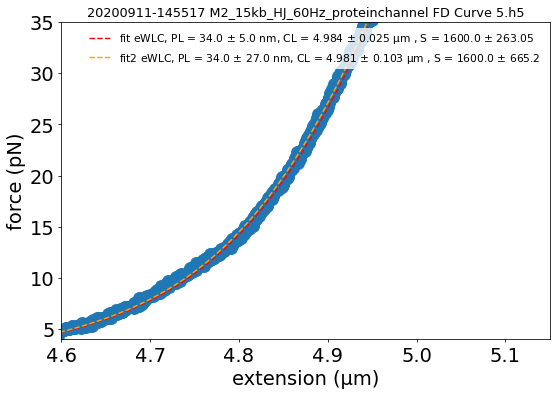

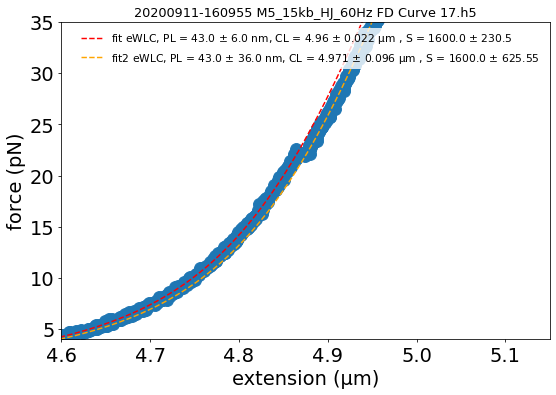

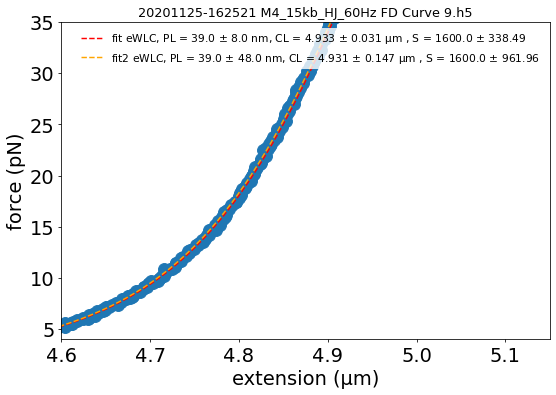

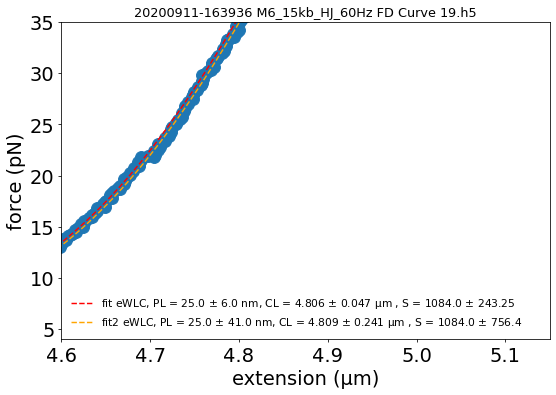

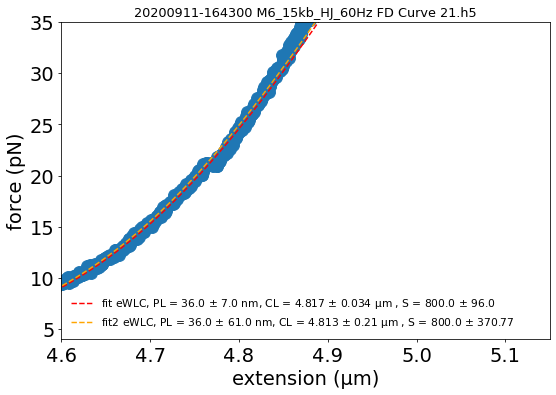

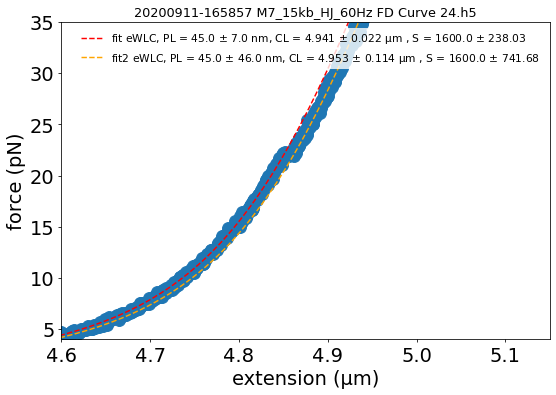

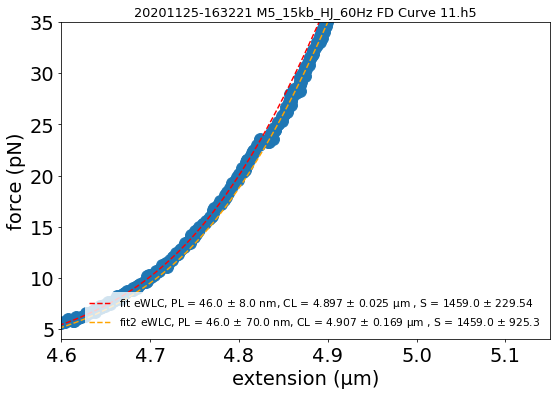

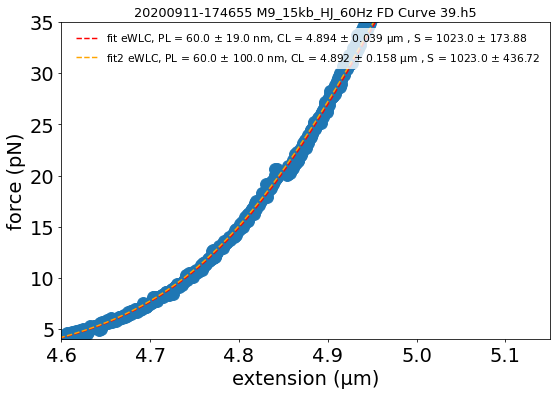

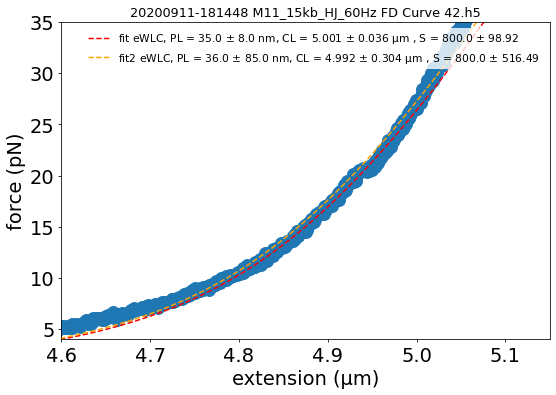

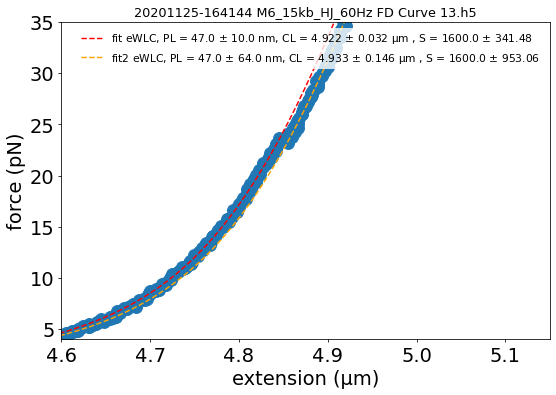

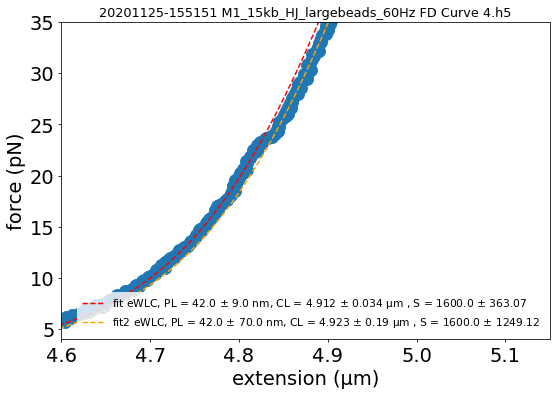

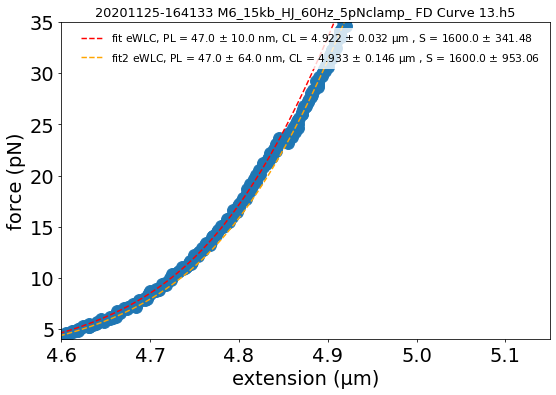

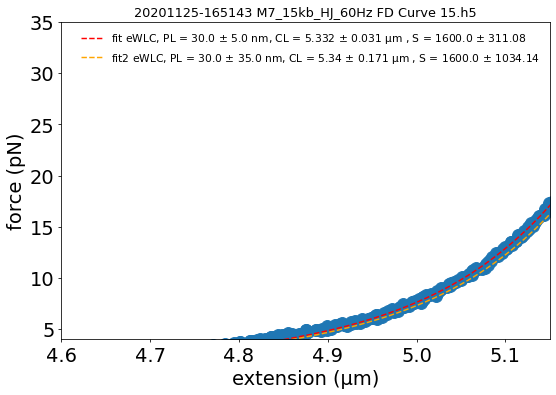

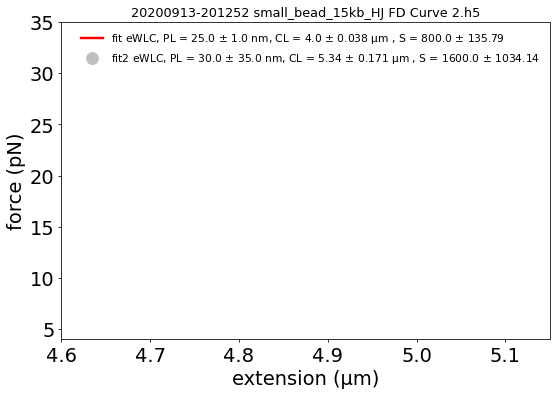

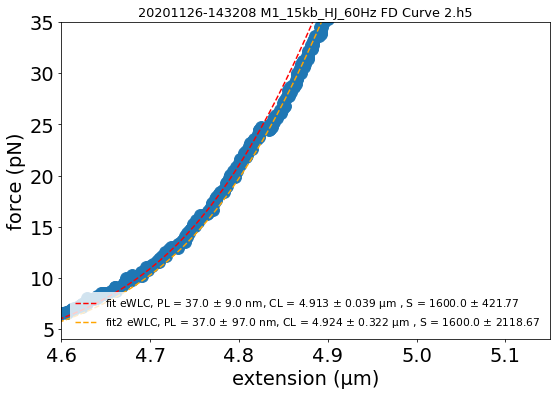

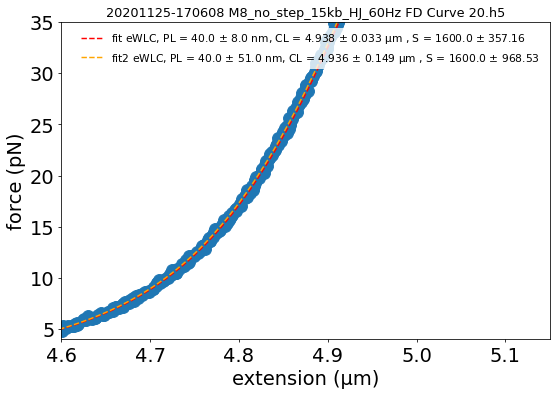

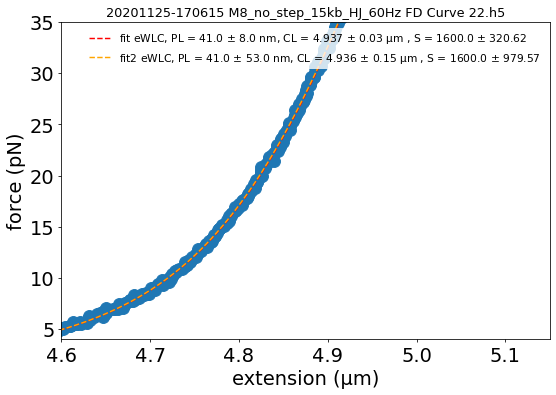

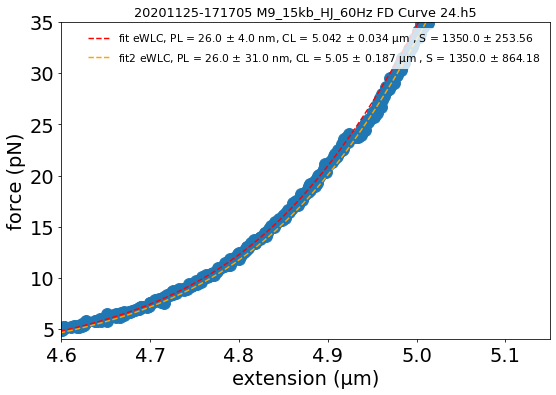

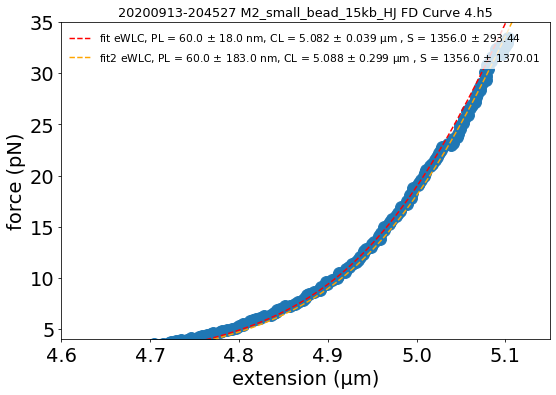

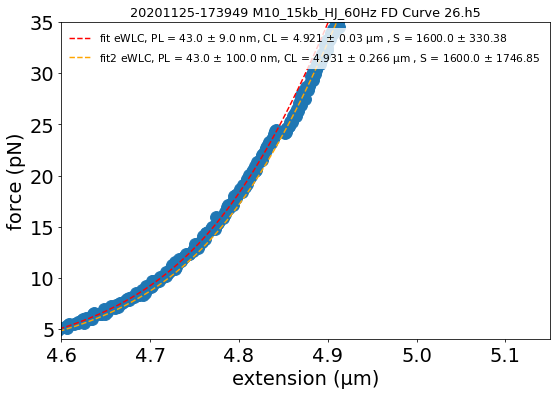

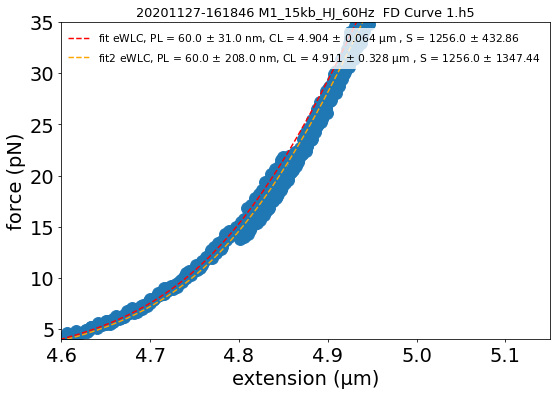

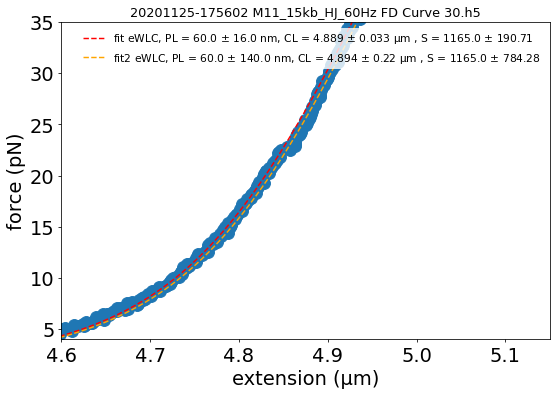

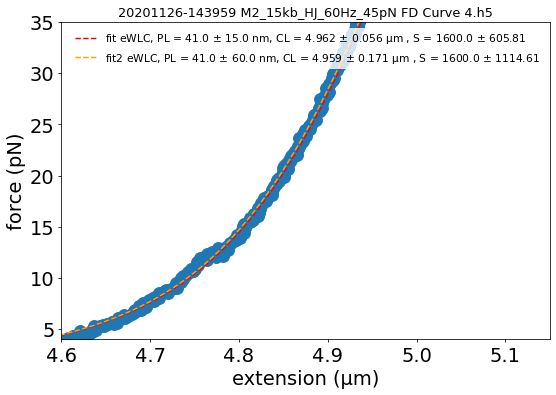

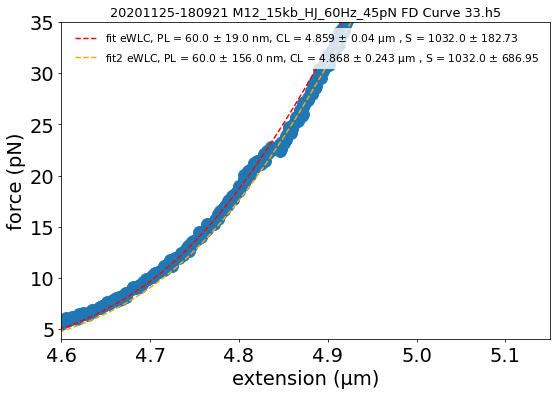

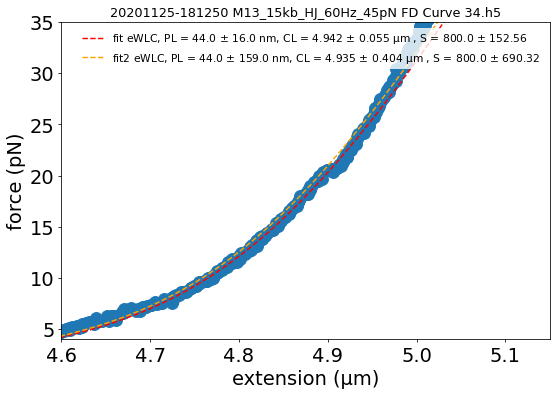

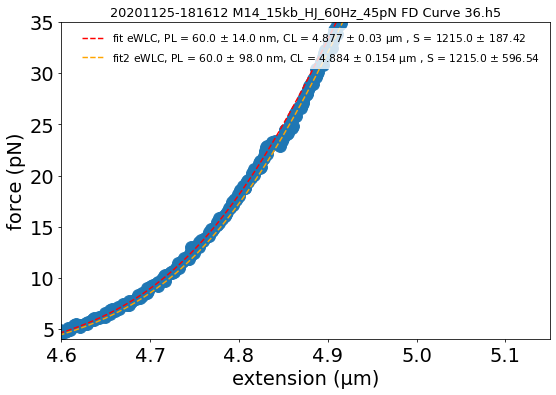

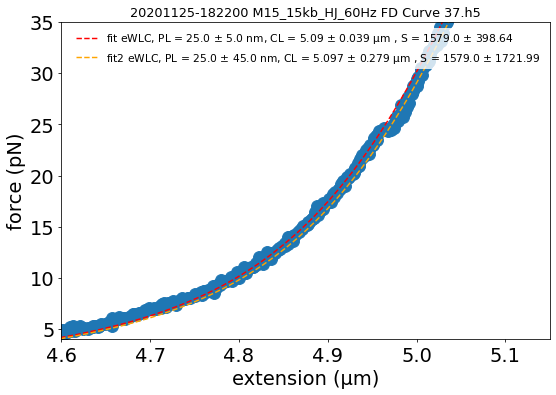

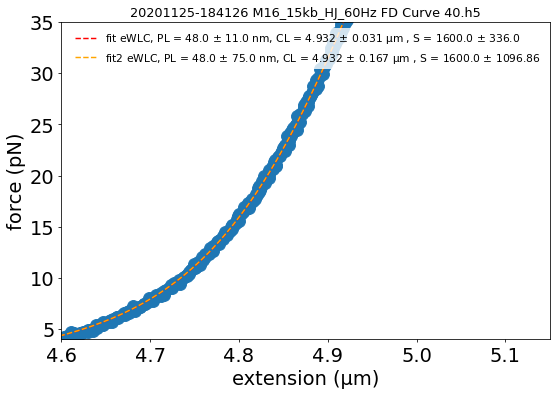

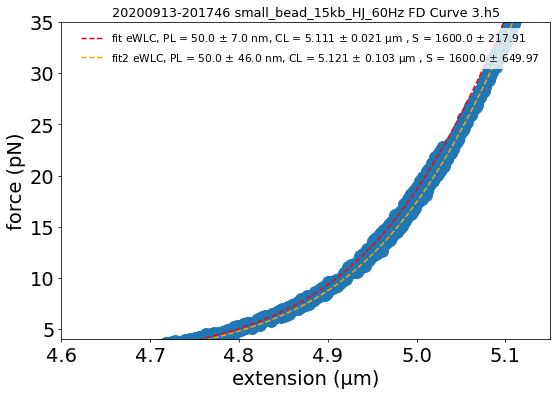

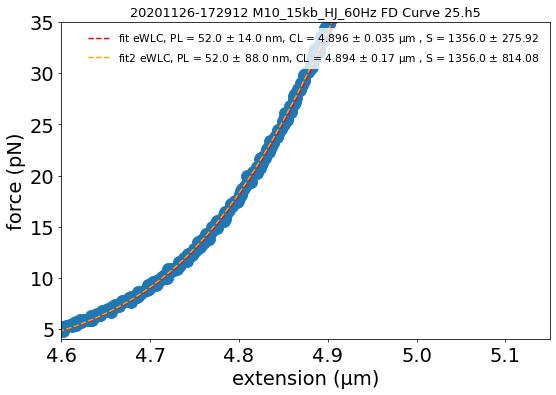

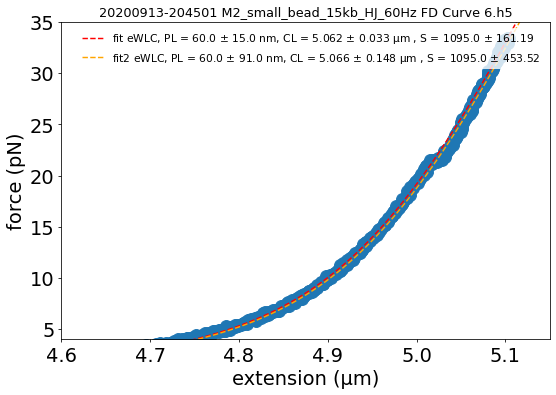

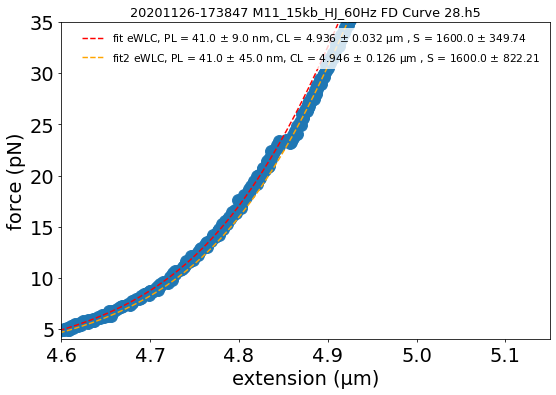

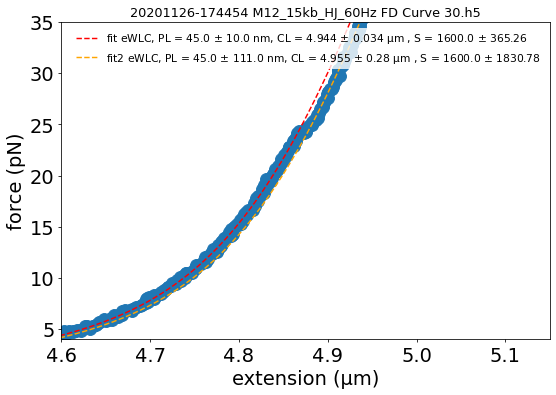

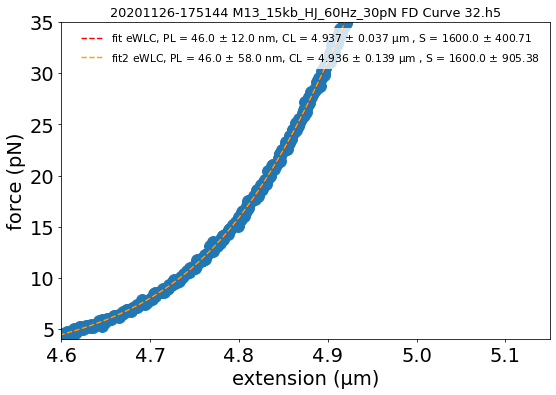

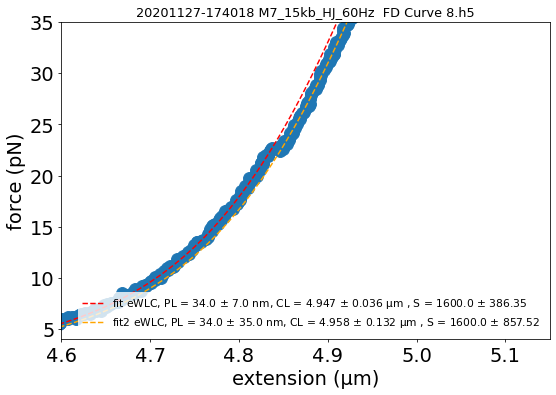

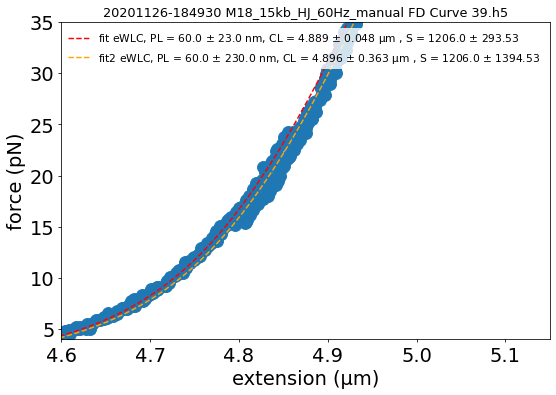

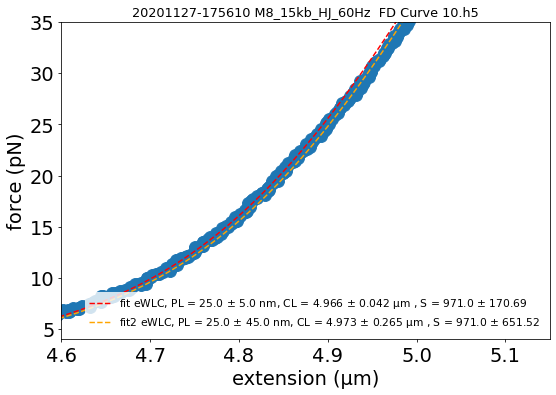

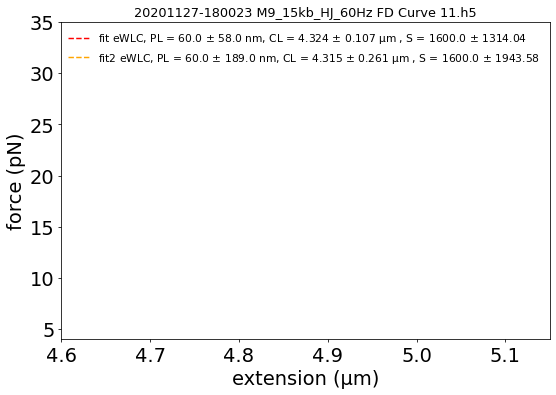

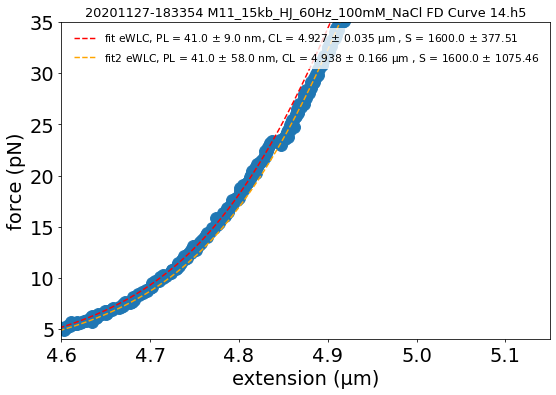

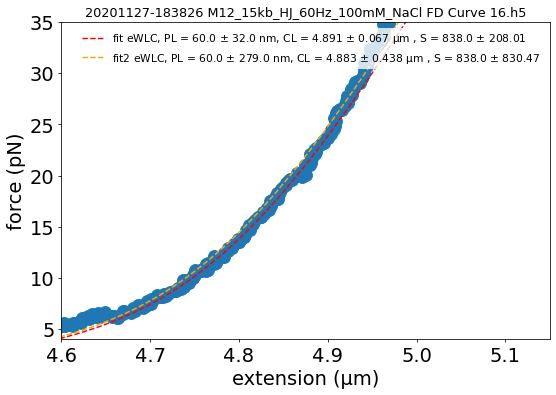

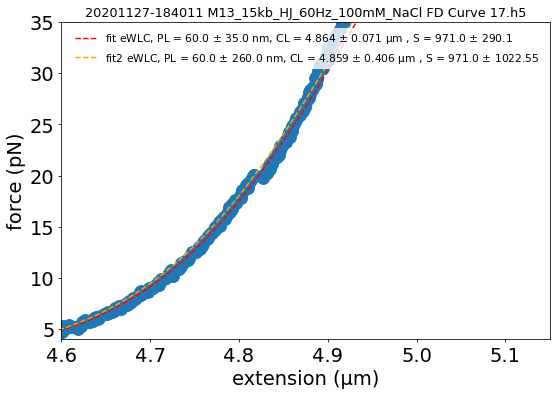

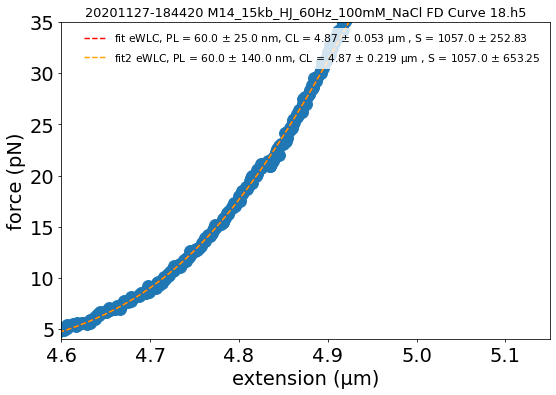

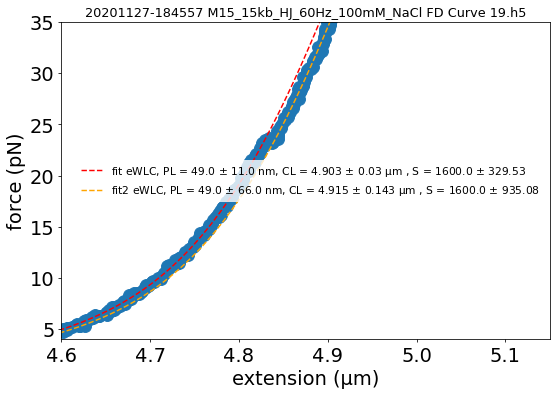

In [62]:
for k in range(len(Filenames)):
    
    
    file = pylake.File(Filenames[k])
    print("Force-distance curve I.D. = " + str(list(file.fdcurves)))
    curve_number = (list(file.fdcurves))   
    
    
    index = 0 # keep ZERO when there is only one FD curve within the .h5 file, increments +1 would correspond with the list of indexes for remaining FD curve generated in the same .h5 file
    
    fd = file.fdcurves[(curve_number[index])]
    force = fd.f
    distance = fd.d

    
    # Stretching curve
    plt.figure(figsize=(9, 6), dpi=70)
    if np.sum(np.diff(distance.data)) > 0:
        
        plt.scatter(distance.data,force.data, s = 150)

        indices_bottom = [i for i,v in enumerate(force.data > force_treshold_min ) if v]
        indices_top = [i for i,v in enumerate(force.data > force_treshold) if v]
        b1 = indices_bottom[0]
        b2 = indices_top[0]

        popt, pcov = curve_fit(eWLC, force.data[b1:b2], distance.data[b1:b2], bounds=([PL_min,CL_min,S_min],[PL_max,CL_max,S_max]))
        perr = np.sqrt(np.diag(pcov)) # standard deviation errors of the parameters
        
        
        indices_bottom2 = [i for i,v in enumerate(force.data > force_treshold_min_2nd ) if v]
        indices_top2 = [i for i,v in enumerate(force.data > force_treshold_2nd) if v]
        b1a = indices_bottom2[0]
        b2a = indices_top2[0]

        popt2, pcov2 = curve_fit(eWLC, force.data[b1a:b2a], distance.data[b1a:b2a], bounds=([popt[0]-0.0001,CL_min,popt[2]-0.01],[popt[0]+0.0001,CL_max,popt[2]+0.01]))
        perr2 = np.sqrt(np.diag(pcov2)) # standard deviation errors of the parameters
        
        #np.savetxt(str(Filenames[k][:-3])+'_fit_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")
    
        #plt.plot(eWLC(np.linspace(force_treshold_min,force_treshold,100), *popt),np.linspace(force_treshold_min,force_treshold,100),  'r-',linewidth=1, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))
        #plt.plot(eWLC(np.linspace(force_treshold_min_2nd,force_treshold_2nd,100), *popt2),np.linspace(force_treshold_min_2nd,force_treshold_2nd,100),  'r-',linewidth=1, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))
        #plt.plot(eWLC(np.linspace(distance.data,force.data,50), *popt),np.linspace(distance.data,force.data,50),'.',color='silver',label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))
        #plt.plot(eWLC(np.linspace(distance.data,force.data,50), *popt2),np.linspace(distance.data,force.data,50),'.',color='silver',label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))
        #plt.plot(eWLC(np.linspace(force.data[0],force.data[-1],100), *popt),np.linspace(force.data[0],force.data[-1],100),'--',color='red',label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))
        #plt.plot(eWLC(np.linspace(force.data[0],force.data[-1],100), *popt2),np.linspace(force.data[0],force.data[-1],100),'--',color='orange',label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))


        plt.plot(eWLC(np.linspace(0.5,40,100), *popt),np.linspace(0.5,40,100),'--',color='red',label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))
        plt.plot(eWLC(np.linspace(0.5,40,100), *popt2),np.linspace(0.5,40,100),'--',color='orange',label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))

        np.savetxt(str(Filenames[k][:-3])+'_data_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")
        np.savetxt(str(Filenames[k][:-3])+'_fit_'+ (curve_number[index]) + '.csv' , np.c_[eWLC(np.linspace(0.5,40,100), *popt),np.linspace(0.5,40,100),eWLC(np.linspace(0.5,40,100), *popt2),np.linspace(0.5,40,100)], delimiter=",")





    
    # Refolding curve
    if np.sum(np.diff(distance.data)) < 0:
        
        plt.scatter(distance.data, force.data, s = 150, color = 'silver')
    
        indices_bottom = [i for i,v in enumerate(force.data > force_treshold_min ) if v]
        indices_top = [i for i,v in enumerate(force.data < force_treshold) if v]
        b1 = indices_bottom[-1]
        b2 = indices_top[0]  
        
        popt, pcov = curve_fit(eWLC,  force.data[b2:b1], distance.data[b2:b1], bounds=([PL_min,CL_min,S_min],[PL_max,CL_max,S_max]))
        perr = np.sqrt(np.diag(pcov)) # standard deviation errors of the parameters
   
        #np.savetxt(str(Filenames[k][:-3])+'_fit_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")

        plt.plot(eWLC(np.linspace(force_treshold_min,force_treshold,100), *popt), np.linspace(force_treshold_min,force_treshold,100),  'r-',linewidth=2.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))

        
    
    plt.xlabel('extension (\u03BCm)')    
    plt.ylabel('force (pN)')   
    
    #plt.xlim(4.65, 4.95)
    #plt.xlim(4.75, 5.05)
    #plt.ylim(8, 35)
    plt.xlim(4.6, 5.15)
    plt.ylim(4, 35)
    
    plt.rc('font', size=11)
    plt.title(str(Filenames[k]))
    leg = plt.legend(('fit eWLC, PL = '+ str(round(popt[0]*1000))+ ' $ \pm $ '+ str(round(perr[0]*1000)) + ' nm, CL = '+str(round(popt[1],3))+ ' $ \pm $ '+ str(round(perr[1],3)) +' \u03BCm , S = ' + str(round(popt[2])) + ' $ \pm $ '+ str(round(perr[2],2)) ,'fit2 eWLC, PL = '+ str(round(popt2[0]*1000))+ ' $ \pm $ '+ str(round(perr2[0]*1000)) + ' nm, CL = '+str(round(popt2[1],3))+ ' $ \pm $ '+ str(round(perr2[1],3)) +' \u03BCm , S = ' + str(round(popt2[2])) + ' $ \pm $ '+ str(round(perr2[2],2)),))
    leg.get_frame().set_linewidth(0.0)

    plt.savefig(str(Filenames[k][:-3])+'_plot_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')
    #np.savetxt('Fd_'+ (curve_number[index]) + '.csv' , np.c_[distance.data[np.argmax(force.data):len(force.data)], force.data[np.argmax(force.data):len(force.data)]], delimiter=",")
    #np.savetxt('Fd_fit'+ (curve_number[index]) + '.csv' , np.c_[d_wave, f_wave], delimiter=",")

    plt.rc('font', size=20)


    #plt.plot(d_wave2, f_wave,'--',color = 'silver')
    #plt.xlabel('extension (\u03BCm)')    
    #plt.ylabel('force (pN)')   
    #plt.xlim(4.8, 4.9)
    #plt.ylim(15, 30)
    #plt.savefig('zoom_FD_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')

